# Lab Deep Learning/ Recurrent Neural Networks/ in pytorch

## Training language model for generating sequences (One-to-Many)

### Lab session recap : A.C.


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime) or a real performer (a musician reading a score).

- We will first train a language model on the whole set of MIDI files of the "Cello suites".
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

## Import packages

In [ ]:
import os
import pretty_midi
from scipy.io import wavfile
import IPython

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import glob
from argparse import Namespace
from tqdm import tqdm

## Parameters of the model

In [34]:
param = Namespace()

param.n_x = 79 # --- input dimension of x<t>, number of musical-pitch considered
param.max_midi_T_x = 1000 # --- maximum considered length of each bach suite
param.model_T_x = 100 # --- considered duration T_x of sequence for training and generation
param.model_n_a = 32 # --- hidden dimension of LSTM

param.dropout_rate = 0.3
param.batch_size = 64
param.n_epoch = 1000

param.model_T_generate = 100 # --- number of time steps to generate

# Get the data

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [ ]:
import urllib.request
urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1FzNBMlhSYdefQUHpfRykY05CsYkuI2Ez', 'Archive.zip')
import shutil
shutil.unpack_archive('Archive.zip', './', 'zip')

DIR = './'
midi_file_l = glob.glob(DIR + 'cs*.mid')
print(midi_file_l)

['.\\cs1-1pre.mid', '.\\cs1-2all.mid', '.\\cs1-3cou.mid', '.\\cs1-4sar.mid', '.\\cs1-5men.mid', '.\\cs1-6gig.mid', '.\\cs2-1pre.mid', '.\\cs2-2all.mid', '.\\cs2-3cou.mid', '.\\cs2-4sar.mid', '.\\cs2-5men.mid', '.\\cs2-6gig.mid', '.\\cs3-1pre.mid', '.\\cs3-2all.mid', '.\\cs3-3cou.mid', '.\\cs3-4sar.mid', '.\\cs3-5bou.mid', '.\\cs3-6gig.mid', '.\\cs4-1pre.mid', '.\\cs4-2all.mid', '.\\cs4-3cou.mid', '.\\cs4-4sar.mid', '.\\cs4-5bou.mid', '.\\cs4-6gig.mid', '.\\cs5-1pre.mid', '.\\cs5-2all.mid', '.\\cs5-3cou.mid', '.\\cs5-4sar.mid', '.\\cs5-5gav.mid', '.\\cs5-6gig.mid', '.\\cs6-1pre.mid', '.\\cs6-2all.mid', '.\\cs6-3cou.mid', '.\\cs6-4sar.mid', '.\\cs6-5gav.mid', '.\\cs6-6gig.mid']


## Read and convert all MIDI files

We illustrate here the content of a MIDI file. Each file contains a list of notes to be played over time. Each note is characterized by
- its `pitch` (in MIDI note number, la3=A4=69)
- its `start` time (when to start playing the note)
- its `stop` time (when to stop playing the note)
- its `duration` (which is computed as stop-start)

In [36]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midi_file_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes[:10]:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 43, start: 0.000000, end: 0.187500, duration: 0.187500
pitch: 50, start: 0.187500, end: 0.375000, duration: 0.187500
pitch: 59, start: 0.375000, end: 0.562500, duration: 0.187500
pitch: 57, start: 0.562500, end: 0.750000, duration: 0.187500
pitch: 59, start: 0.750000, end: 0.937500, duration: 0.187500
pitch: 50, start: 0.937500, end: 1.125000, duration: 0.187500
pitch: 59, start: 1.125000, end: 1.312500, duration: 0.187500
pitch: 50, start: 1.312500, end: 1.500000, duration: 0.187500
pitch: 43, start: 1.500000, end: 1.687500, duration: 0.187500
pitch: 50, start: 1.687500, end: 1.875000, duration: 0.187500


For each MIDI file,
- we read it
- we only retain the `pitch` information (we name it `note`) .
- we convert this list of notes (`note_l`)  to a one-hot-encoding matrix `X_ohe` of dimensions `(midi_T_x, param.n_x)` where `param.n_x` is the number of possible musical notes.

Remark: the length of the sequences `midi_T_x` can vary from one sequence to the other but is truncated to `param.max_midi_T_x`.



___
#### My remark :

For the one-hot-encoding to work, we neet each pitch to have its own index, and keep the same index across all the different datasets (midi file). I made this small function below that returns the smallest pitch index to begin our one-hot-encoding, and then I use this value within the function to make sure I don't have an index error on dim = 1.

In [37]:
def min_pitch(midi_file_l,max_midi_T_x):
    min_pitch_value = np.inf
    for midi_file in midi_file_l:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        note_l = [note.pitch for note in midi_data.instruments[0].notes]
        midi_T_x = min(len(note_l),max_midi_T_x)
        for note in note_l[:midi_T_x]:
            min_pitch_value = min(note,min_pitch_value)
    return(min_pitch_value)

print(min_pitch(midi_file_l,param.max_midi_T_x))

36


___

In [ ]:
def F_convert_midi_2_list(midi_file_l, n_x, max_midi_T_x):
    """
    read the notes within all midi files
    truncate the length if > max_midi_T_x

    Parameters
    ----------
    midi_file_l:
        list of MIDI files
    n_x:
        dimension of the one-hot-encoding
    max_midi_T_x:
        the maximum number of notes we read in a given midi_file

    Returns
    -------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time
    """
    X_list = []
    
    for midi_file in midi_file_l:
        # --- read the MIDI file
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        note_l = [note.pitch for note in midi_data.instruments[0].notes]
        midi_T_x = len(note_l) if len(note_l) < max_midi_T_x else max_midi_T_x
        # --- convert to one-hot-encoding
        X_ohe = np.zeros((midi_T_x,n_x))
        for i,note in enumerate(note_l[:midi_T_x]):
            X_ohe[i,note-36]=1 # 36 = min_pitch(midi_file_l=midi_file_l,max_midi_T_x=max_midi_T_x), see explanation above
        # --- add X_ohe to the list X_list
        X_list.append(X_ohe)

    return X_list

In [39]:
X_list = F_convert_midi_2_list(midi_file_l, param.n_x, param.max_midi_T_x)
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(593, 79)
(914, 79)
(812, 79)


## Display the set of notes over time for a specific track

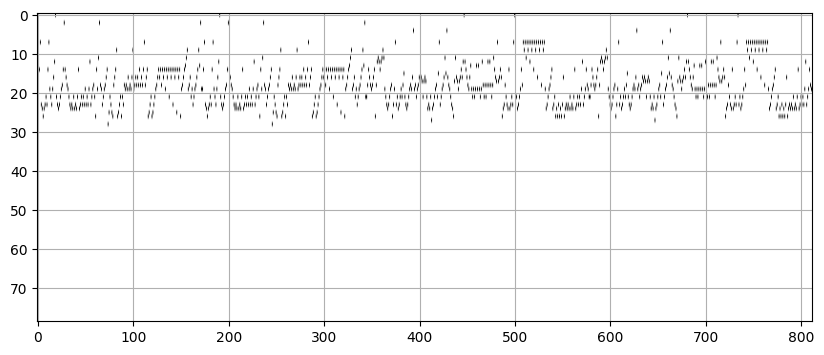

In [40]:
plt.figure(figsize=(10, 4))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

We want to train a language model, i.e. a model thats predict a note given past notes: $p(x^{<\tau>} | x^{<1>}, x^{<2>}, ... x^{<\tau-1>})$.

A simple way to do this is to create (for each MIDI sequence and for each possible starting note `t` within this MIDI sequence) two sequences:
- an input sequence $\{x\}$:
  - which contains a sub-sequence of length `param.model_T_x`;  this sub-sequence range from `t` to `t+param.model_T_x-1`
- an output sequence $\{y\}$ :
  - which contains the same sub-sequence but delayed by one time step: ranging from `t+1` to `t+param.model_T_x`

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_03.png">



In [ ]:
def F_convert_list_2_data(X_list, model_T_x, sequence_step=1):
    """
    convert X_list to input X_train and output Y_train training data

    Parameters
    ----------
    X_list:
        a list of np.array X_ohe of size (midi_T_x, n_x) which contains the one-hot-encoding representation of notes over time
    model_T_x:
        the length of the input and output sequences
    sequence_step:
        the advancement step between successive sequences

    Returns
    -------
    X_train:
        the set of all m input sequences; np.array of shape (m, model_T_x, n_x)
    Y_train:
        the set of all m output sequences; np.array of shape (m, model_T_x, n_x)

            note:   m is the total number of training items,
                    it will be larger than the number of MIDI files since we use several starting time t in each MIDI file
    """
    X_train_list = []
    Y_train_list = []
    for X_ohe in X_list:
        midi_T_x = np.shape(X_ohe)[0]
        t = 0
        while t + model_T_x < midi_T_x: #To prevent index error
            X_intput_seq = X_ohe[t:t+model_T_x]
            Y_output_seq = X_ohe[t+1:t+1+model_T_x]
            X_train_list.append(X_intput_seq)
            Y_train_list.append(Y_output_seq)
            t+=sequence_step  
    X_train = np.asarray(X_train_list)
    Y_train = np.asarray(Y_train_list)

    return X_train, Y_train

X_train.shape: (20901, 100, 79)
Y_train.shape: (20901, 100, 79)


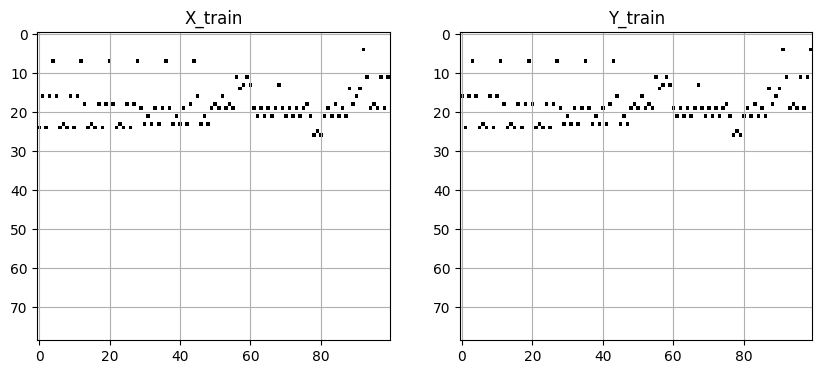

In [42]:
X_train, Y_train = F_convert_list_2_data(X_list, param.model_T_x)
# --- X_train is of shape (m, model_T_x, n_x)
print("X_train.shape:", X_train.shape)
# --- Y_train is of shape (m, model_T_x, n_x)
print("Y_train.shape:", Y_train.shape)


plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.imshow(X_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('X_train')
plt.subplot(1,2,2); plt.imshow(Y_train[20,:,:].T, aspect='auto'); plt.grid(True); plt.title('Y_train')
plt.set_cmap('gray_r')

# Training the language model

## Creating the model
To learn the language model we will train an RNN with input `X_train` and output `Y_train`.  
For each example, we give to the network a sequence of notes from `t` to `t+param.model_T_x-1`  and ask the network to predict the following note of each sequence `t+1` to `t+param.model_T_x`.
We already created those in `X_train` and `Y_train`.

The network architecture is the following:
- (1a) a layer of `LSTM` with `param.model_n_a` units
- (1b) a layer of DropOut with rate `param.dropout_rate` (which is the probability to "drop-out" one neuron)

- (2a) a layer of `LSTM` with `param.model_n_a` units
- (2b) a layer of DropOut with rate `param.dropout_rate` (which is the probability to "drop-out" one neuron)

- (3) a layer of `LSTM` with `param.model_n_a` units

- (4a) a `Linear` layer projecting to `model_n_a` neurons with a `tanh` activation
- (4b) a layer of DropOut with rate `param.dropout_rate` (which is the probability to "drop-out" one neuron)

- (5) a `Linear` layer projecting to `n_x` neurons

Note that the last `softmax` activation (which predict the probability of each of the $n_x$ notes as output) is not included in the model but will be included directly in the Loss.

Note that the `.forward` method
- also takes as **input** the previous RNN values $s^{(t-1)}$. The previous RNN value sums up the times $x^{(1)} ... x^{(t-1)}$.
In the case of LSTM, $s^{(t-1)}$ is actually a tuple which represent the LSTM hidden state value $h^{(t-1)}$ and LSTM cell (memory) value $c^{(t-1)}$.
Also when several layers of LSTM exist, each layer will have a specific $s^{(t-1)}$ (such as $s^{(t-1),[1]}$, $s^{(t-1),[2]}$ and $s^{(t-1),[3]}$ for three layers).
- also **outputs** the new value of those $s^{(t),[1]}$, $s^{(t),[2]}$ and $s^{(t),[3]}$.

$h$ and $c$ are merged into tuples named `hidden` and since we have three LSTM cell we will have the corresponding `hidden1`, `hidden2` and `hidden3`.   

In [ ]:
# --- Create the model

class BachModel(nn.Module):
    def __init__(self, param):
        """
        """
        super(BachModel,self).__init__()
        self.LTSM1 = nn.LSTM(param.n_x,param.model_n_a,batch_first=True)
        self.droupout1 = nn.Dropout(param.dropout_rate)
        self.LSTM2 = nn.LSTM(param.model_n_a,param.model_n_a,batch_first=True)
        self.droupout2 = nn.Dropout(param.dropout_rate)
        self.LSTM3 = nn.LSTM(param.model_n_a,param.model_n_a,batch_first=True)
        self.linear1 = nn.Linear(param.model_n_a,param.model_n_a)
        self.tanh = nn.Tanh()
        self.dropout3 = nn.Dropout(param.dropout_rate)
        self.linear2 = nn.Linear(param.model_n_a,param.n_x)

    def forward(self, x, hidden1, hidden2, hidden3):
        """
        Parameters
        ----------
            x (batch_size, T_x, n_x)
                a batch of input sequences
            hidden1
                a tuple with hidden state h and cell c, each of size (1, batch_size, n_a), to be used as start for lstm of layer1
            hidden2
                same for layer 2
            hidden3
                same for layer 3

        Returns
        -------
            logits (batch_size, T_x, n_x)
                predicted logits (before softmax)
            hidden1
                new value after processing sequence T_x
            hidden2
                new value after processing sequence T_x
            hidden2
                new value after processing sequence T_x
        """
        y1, hidden1 = self.LTSM1(x,hidden1)
        y1 = self.droupout1(y1)
        y2, hidden2 = self.LSTM2(y1,hidden2)
        y2 = self.droupout2(y2)
        y3, hidden3 = self.LSTM3(y2,hidden3)
        output = self.linear1(y3)
        output = self.tanh(output)
        output = self.dropout3(output)
        logits = self.linear2(output)
        return logits, hidden1, hidden2, hidden3

    def init_hidden(self, batch_size, model_n_a):
        """
        """
        # Initialize hidden state and cell state with zeros
        hidden1 = (torch.zeros(1, batch_size, model_n_a).float().to(device),
                    torch.zeros(1, batch_size, model_n_a).float().to(device))
        hidden2 = (torch.zeros(1, batch_size, model_n_a).float().to(device),
                    torch.zeros(1, batch_size, model_n_a).float().to(device))
        hidden3 = (torch.zeros(1, batch_size, model_n_a).float().to(device),
                    torch.zeros(1, batch_size, model_n_a).float().to(device))
        return hidden1, hidden2, hidden3

# We fix the seed
torch.manual_seed(0)

# --- check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the model and send it to the GPU if available
model = BachModel(param).to(device)
hidden1, hidden2, hidden3 = model.init_hidden(param.batch_size, param.model_n_a)
print(model)



Using device: cuda
BachModel(
  (LTSM1): LSTM(79, 32, batch_first=True)
  (droupout1): Dropout(p=0.3, inplace=False)
  (LSTM2): LSTM(32, 32, batch_first=True)
  (droupout2): Dropout(p=0.3, inplace=False)
  (LSTM3): LSTM(32, 32, batch_first=True)
  (linear1): Linear(in_features=32, out_features=32, bias=True)
  (tanh): Tanh()
  (dropout3): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=32, out_features=79, bias=True)
)


C:\Users\Doudous\AppData\Local\Temp\ipykernel_11804\702340037.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.subplot(212), plt.imshow(F.softmax(output[0,:,:]).detach().cpu().T.numpy(), aspect='auto', origin='lower', interpolation='none');


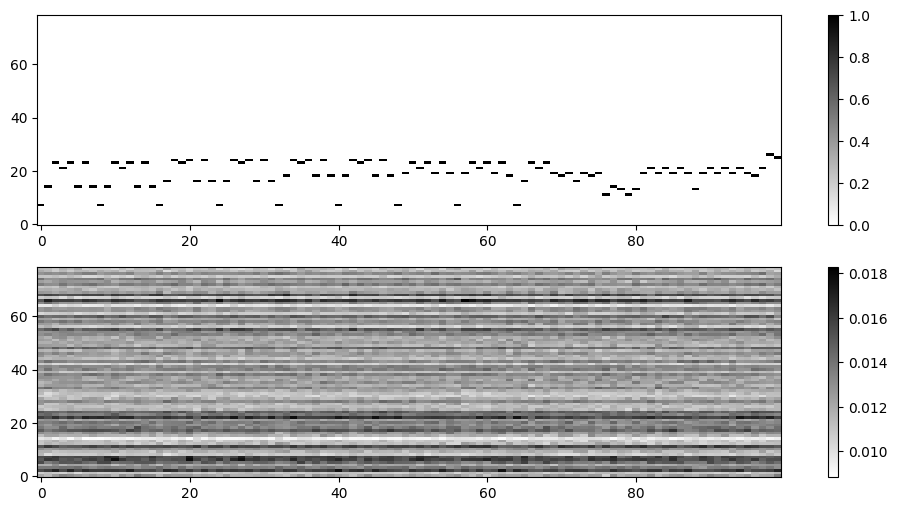

In [44]:
def plot_test(X_train):
    """
    Display the obtained probability estimation for a given sequence
    """
    # ----------------------------------------------
    input = torch.tensor(X_train[:1,:,:]).float()
    hidden1, hidden2, hidden3 = model.init_hidden(input.size(0), param.model_n_a)
    output, _, _, _ = model( input.to(device), hidden1, hidden2, hidden3 )
    #print(f'input: {input.size()} hidden1: {hidden1[0].size()} output: {output.size()}')

    plt.figure(figsize=(12,6))
    plt.subplot(211), plt.imshow(input[0,:,:].T.numpy(), aspect='auto', origin='lower', interpolation='none');
    plt.colorbar()
    plt.subplot(212), plt.imshow(F.softmax(output[0,:,:]).detach().cpu().T.numpy(), aspect='auto', origin='lower', interpolation='none');
    plt.colorbar()
    plt.show()

plot_test(X_train)

In [45]:
def train_one_epoch(model, data_loader, criterion, optimizer):
    """
    """

    model.train()
    total_loss = 0
    for X, y in data_loader:
        optimizer.zero_grad()
        # --- X (m, T_x, n_x)
        m = X.size(0)
        hidden1, hidden2, hidden3 = model.init_hidden(m, param.model_n_a)
        hat_y, _, _, _ = model( X, hidden1, hidden2, hidden3 )
        hat_y = hat_y.view(m * param.model_T_x, param.n_x)
        y_bol = torch.argmax(y, dim=2)
        y_bol = y_bol.view(m * param.model_T_x)

        loss = criterion(hat_y, y_bol)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

In [46]:
def train(model, X_train, Y_train, epochs=param.n_epoch, batch_size=param.batch_size):
    # --- Move the model to the device (GPU or CPU)
    model = model.to(device)

    # ---  Convert numpy.arrays to torch.tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

    # ---  Create Datasets for train data
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

    # --- Create Dataloader for train data
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # ---  Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=0.01)

    # ---  Training loop
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        if epoch%100==0:
            print(f"Epoch {epoch + 1}, Loss: {train_loss }")
            plot_test(X_train)

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1, Loss: 3.022442550105057


C:\Users\Doudous\AppData\Local\Temp\ipykernel_11804\702340037.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.subplot(212), plt.imshow(F.softmax(output[0,:,:]).detach().cpu().T.numpy(), aspect='auto', origin='lower', interpolation='none');


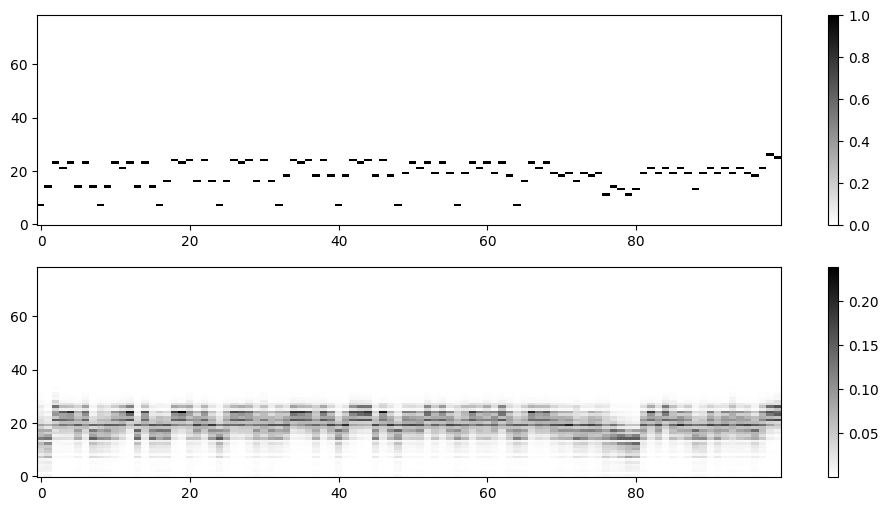

Training Progress:  10%|█         | 100/1000 [06:52<1:02:59,  4.20s/it]

Epoch 101, Loss: 1.6775466240145016


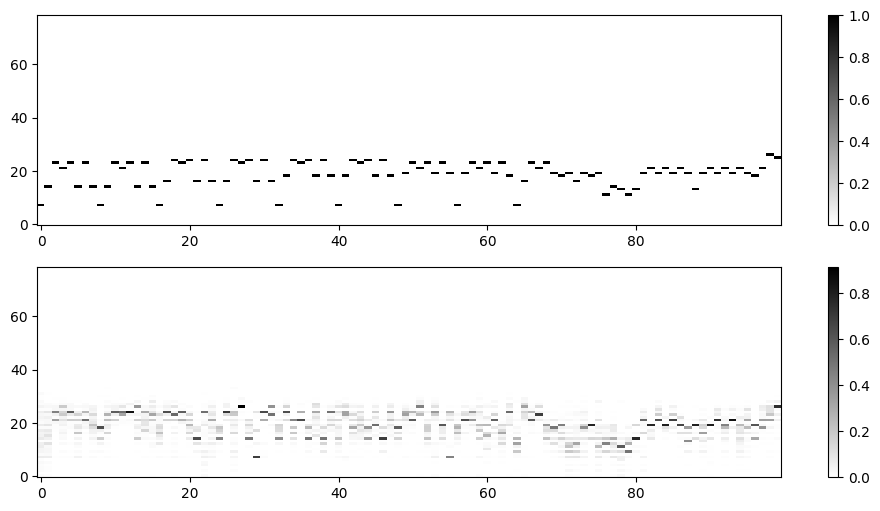

Training Progress:  20%|██        | 200/1000 [13:35<54:47,  4.11s/it]  

Epoch 201, Loss: 1.6441048996164165


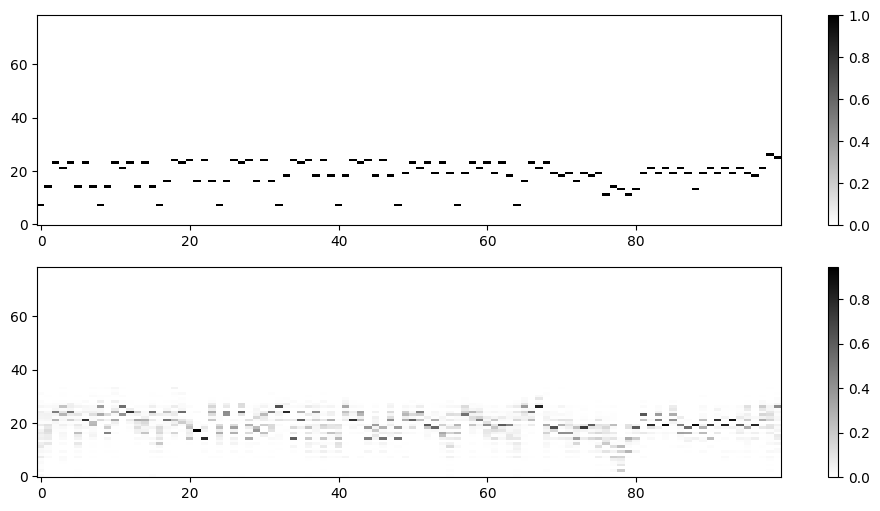

Training Progress:  30%|███       | 300/1000 [20:26<47:47,  4.10s/it]

Epoch 301, Loss: 1.6228001628082462


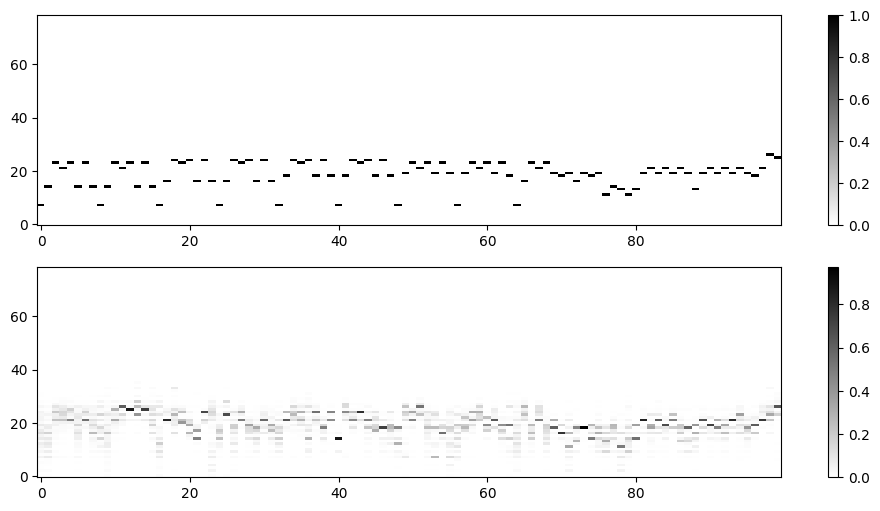

Training Progress:  40%|████      | 400/1000 [27:16<41:17,  4.13s/it]

Epoch 401, Loss: 1.6131522815890997


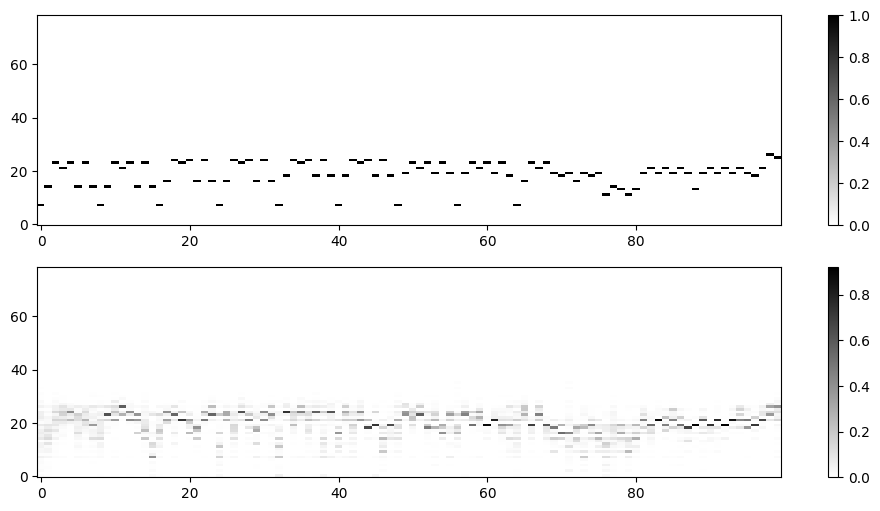

Training Progress:  50%|█████     | 500/1000 [34:05<34:05,  4.09s/it]

Epoch 501, Loss: 1.604432003213725


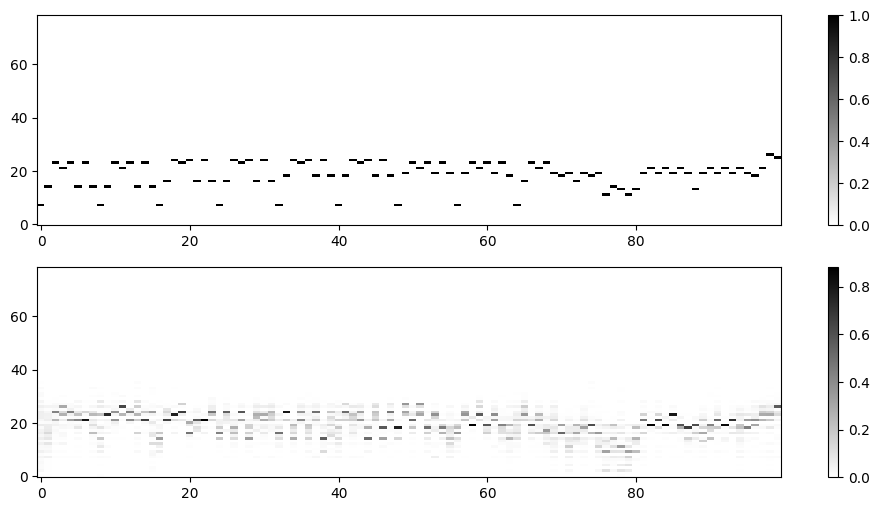

Training Progress:  60%|██████    | 600/1000 [40:55<27:24,  4.11s/it]

Epoch 601, Loss: 1.608794766464


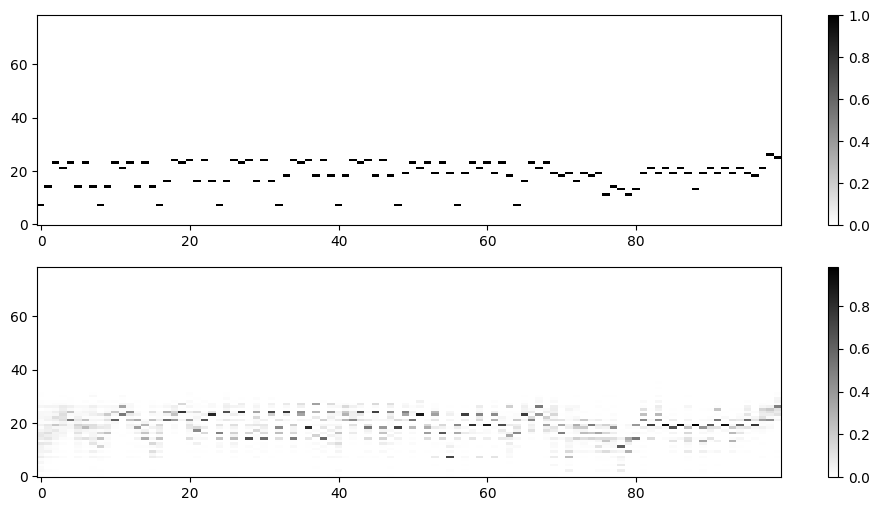

Training Progress:  70%|███████   | 700/1000 [47:45<20:32,  4.11s/it]

Epoch 701, Loss: 1.593466133152673


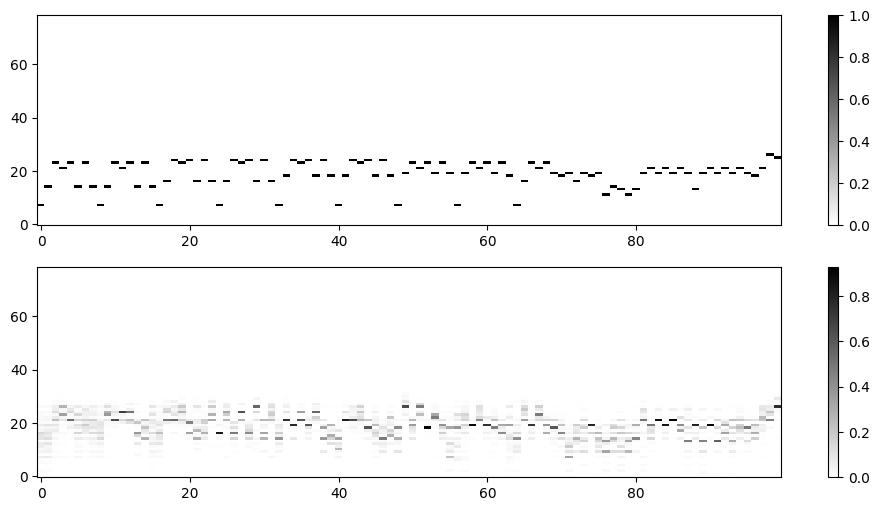

Training Progress:  80%|████████  | 800/1000 [54:35<13:39,  4.10s/it]

Epoch 801, Loss: 1.5899384564945092


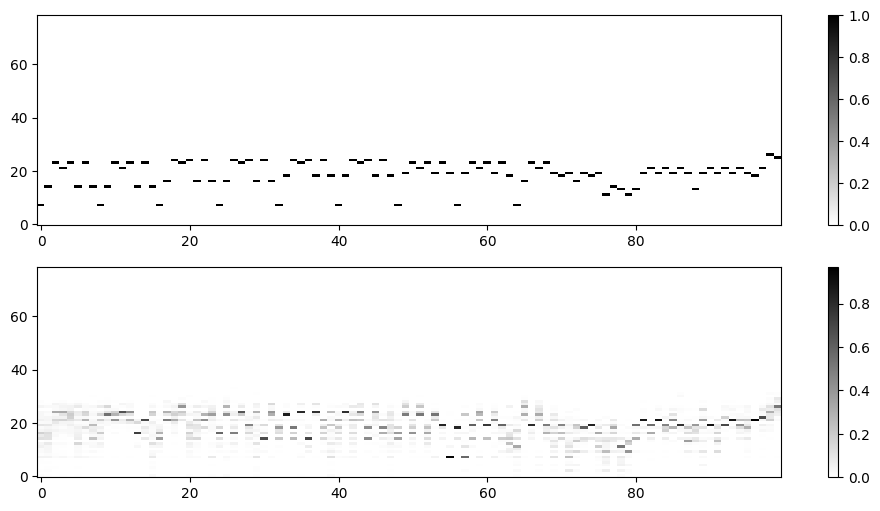

Training Progress:  90%|█████████ | 900/1000 [1:01:28<06:49,  4.09s/it]

Epoch 901, Loss: 1.9274940326673176


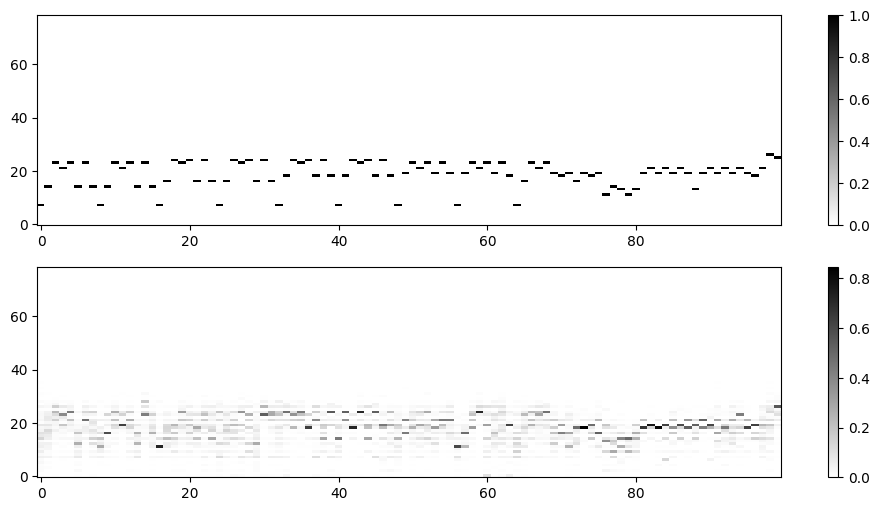

Training Progress: 100%|██████████| 1000/1000 [1:08:18<00:00,  4.10s/it]


In [47]:
train(model, X_train, Y_train)

# Generating a new sequence by sampling the language model

<img src="https://docs.google.com/uc?export=download&id=18zpnW4XPnqxRQCaV3vtuL6e1xBiFPFzH" width=900>


To generate a new sequence using the trained language model, we will use an **auto-regressive** method: we generate time-step $t$ based on the previously generated time-steps $0$ to $t-1$.

For the first step
- $\hat{y}^{(1)} = p(x^{(2)} | \color{red}{x^{(1)}} ; \color{blue}{s^{(0)}=[-]})\\x^{(2)} \sim \hat{y}^{(1)}$

For the second step
- $\hat{y}^{(2)} = p(x^{(3)} | \color{red}{x^{(2)}} ; \color{blue}{s^{(1)}=[x^{(1)}]})\\x^{(3)} \sim \hat{y}^{(2)}$

The third step
- $\hat{y}^{(3)} = p(x^{(4)} |\color{red}{ x^{(3)}} ; \color{blue}{s^{(2)}=[x^{(1)} x^{(2)}]})\\x^{(4)} \sim \hat{y}^{(3)}$

For the $t$ step:
- $\hat{y}^{(t)} = p(x^{(t+1)} | \color{red}{{x^{(t)}}} ; \color{blue}{s^{(t-1)}=[x^{(1)} ... x^{(t-1)}]})\\x^{(t+1)} \sim \hat{y}^{(t)}$

In the above "$\sim$" denotes "sampled from the distribution"

At time step $t$, the model gets
- as input (red part): the previous generated time step $x^{(t)} \sim \hat{y}^{(t-1)}$
- as previous RNN value (blue part) $s^{(t-1)}$. The previous RNN value sums up the times $x^{(1)} ... x^{(t-1)}$.
In the case of LSTM, $s^{(t-1)}$ is actually a tuple which represent the LSTM hidden state value $h^{(t-1)}$ and LSTM cell (memory) value $c^{(t-1)}$.
Also when several layers of LSTM exist, each layer will have a specific $s^{(t-1)}$ (such as $s^{(t-1),[1]}$, $s^{(t-1),[2]}$ and $s^{(t-1),[3]}$ for three layers).


### Initialisation (`t=1`)

For the start, we set $x^{(1)}$ to a randomly choosen note among the `param.n_x` possible notes. For this you can
- either sample from an uniform distribution among the notes -> `get_prior_uniform`
- or sample from a prior note distribution (the prior can be obtained by counting the number of occurences of each notes in the training set) -> `get_prior_data_distribution`

To sample from a distribution you can use `np.random.multinomial`.

We then create an input `x` that will be used by our `model`. Our model requires data of shape `(m, T_x, n_x)`. In our case
- `m=1` since we have only one sequence,
- `T_x=1` since we only consider one time at a given time (auto-regressive)
- `n_x` is the number of notes.

We set the input data `x[0,0,:]` to the one-hot-encoding of our random note $x^{(1)}$.

For the start, we do not have previous RNN values, we therefore set $s^{(0)}$ to 0.
This is done using `model.init_hidden`. We denote those `hidden1, hidden2, hidden3`.

We then feed our model with data `x[0,0,:]` and `hidden1, hidden2, hidden3`.

### Loop

At time $t$, our model predict $\hat{y}^{(t)}=p(x^{(t+1)} | \color{red}{{x^{(t)}}} ; \color{blue}{s^{(t-1)}=[x^{(1)} ... x^{(t-1)}]})$.

The inputs of the model are
- the one-hot-encoding of the previously chosen note $x^{(t)} \sim \hat{y}^{(t-1)}$; it is stored in `x[0,0,:]`
- the previous RNN value $s^{(t-1)}$; it is stored in `hidden1, hidden2, hidden3`

The outputs of `model.forward()` are
- the `logits` $\in [-\inf,\inf]$ of shape `(1, 1, n_x)` of each note (remember that the `softmax` is not part of our model; the softmax is included in the Loss, not in the model).
- the new RNN values $s^{(t)}$

To get $\hat{y}^{(t)}$ from the logits at time `t`, we can  
- (a) either convert this logit vector to a probablity using standard softmax -> `get_softmax`
- (b) or convert this logit vector to a probablity using a softmax **with temperature** -> `get_softmax_temperature`.
To apply a temperature $T$ parameter to a discrete probability $\{p_c\}_{c \in \{1,...,K\}}$, you can use
$p'_c = \frac{e^{\log(p_c)/T}}{\sum_{k=1}^K e^{\log(p_k)/T}}$ where $K$ is the number of classes.

To get $x^{(t+1)}$ from the resulting probablity $\hat{y}^{(t)}$ we can then
- (a) either select the largest probability -> `np.argmax`
- (b) or consider the probability as a multinomial distribution and sample from it -> `np.random.multinomial`.

We append the chosen note $x^{(t+1)}$ to the list of chosen notes ->  `note_l.append()`.
We append the used probablity $\hat{y}^{(t)}$ to the list of probablities -> `prediction_l.append()`.

### Stop criteria

We repeat the process until we generate the required amount of notes `param.model_T_generate`.





In [ ]:
# --- np: numpy
# --- to: pytorch

def get_prior_uniform(n_x):
    """
    """
    prior_np_v = np.ones(n_x)/n_x
    return prior_np_v

def get_prior_data_distribution(X_train_np, n_x):
    """
    """
    sum_np_v = np.zeros(n_x)
    for X_ohe_np in X_train_np:
        sum_np_v += np.sum(X_ohe_np, axis=0)
    prior_np_v = sum_np_v/np.sum(sum_np_v)
    return prior_np_v

def get_softmax(hat_logit_to):
    """
    """
    proba_np_v = F.softmax( hat_logit_to.double() ).cpu().detach().numpy()
    return proba_np_v

def get_softmax_temperature(hat_logit_to, temperature):
    """
    compute a softmax with temperature

    Parameters
    ----------
    logits_v: n_x
        input un-normalized logits \in [-inf, inf]
    temperature: scalar float
        temperature parameters to apply to proba_v,
        >1 leads to more flatten probability,
        <1 leads to more peaky probability

    Returns
    -------
    proba_v: np.array(n_x)
        probability scaled by temperature
    """
    hat_logit_to = hat_logit_to / temperature
    proba_np_v = get_softmax(hat_logit_to)
    return proba_np_v

def choose_max(proba_np_v):
    """
    """
    index_pred = np.argmax(proba_np_v)
    return index_pred

def choose_max_multinormial(proba_np_v):
    """
    """
    index_pred = np.argmax(np.random.multinomial(1, proba_np_v))
    return index_pred

## Softmax temperature formula :

$$ \dfrac{\exp(\frac{z_i}{T})}{\sum _j \exp(\frac{z_j}{T})} $$

In [ ]:
def F_sample_new_sequence(model):
    """
    sample the trained language model to generate new data

    Parameters
    ----------
    model:
        trained language model

    Returns
    -------
    note_l: list of int
        list of generated notes (list of their index)
    prediction_l: list of np.array(n_x)
        list of prediction probabilies over time t (each entry of the list is one of the y[0,t,:])
    """

    np.random.seed(0)
    note_l = []
    prediction_l = []
    first_note_index = np.argmax(np.random.multinomial(1,get_prior_uniform(param.n_x)))
    x = np.zeros((1, param.model_T_x, param.n_x))
    x[0,0,first_note_index] = 1
    hidden1, hidden2, hidden3 = model.init_hidden(1, param.model_n_a)
    for t in range(param.model_T_generate):
        hat_logit_to, hidden1, hidden2, hidden3 = model(torch.tensor(x).float().to(device), hidden1, hidden2, hidden3)
        proba_np_v = get_softmax_temperature(hat_logit_to[0, 0, :], temperature=3)
        note_index = np.argmax(np.random.multinomial(1, proba_np_v))
        prediction_l.append(proba_np_v)
        note_l.append(note_index)
        x = np.zeros((1,1,param.n_x))
        x[0,0,note_index] = 1
    return note_l, prediction_l

### Display the generated sequence

C:\Users\Doudous\AppData\Local\Temp\ipykernel_11804\3629712536.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba_np_v = F.softmax( hat_logit_to.double() ).cpu().detach().numpy()


[np.int64(17), np.int64(32), np.int64(39), np.int64(5), np.int64(14), np.int64(19), np.int64(24), np.int64(43), np.int64(16), np.int64(15), np.int64(11), np.int64(19), np.int64(30), np.int64(26), np.int64(24), np.int64(18), np.int64(0), np.int64(4), np.int64(20), np.int64(23), np.int64(6), np.int64(9), np.int64(16), np.int64(21), np.int64(16), np.int64(17), np.int64(14), np.int64(17), np.int64(16), np.int64(6), np.int64(4), np.int64(10), np.int64(23), np.int64(26), np.int64(33), np.int64(20), np.int64(22), np.int64(29), np.int64(30), np.int64(28), np.int64(29), np.int64(25), np.int64(24), np.int64(23), np.int64(14), np.int64(28), np.int64(19), np.int64(4), np.int64(20), np.int64(17), np.int64(9), np.int64(19), np.int64(6), np.int64(17), np.int64(2), np.int64(0), np.int64(27), np.int64(19), np.int64(26), np.int64(18), np.int64(0), np.int64(0), np.int64(19), np.int64(21), np.int64(0), np.int64(19), np.int64(12), np.int64(17), np.int64(2), np.int64(12), np.int64(10), np.int64(22), np.int6

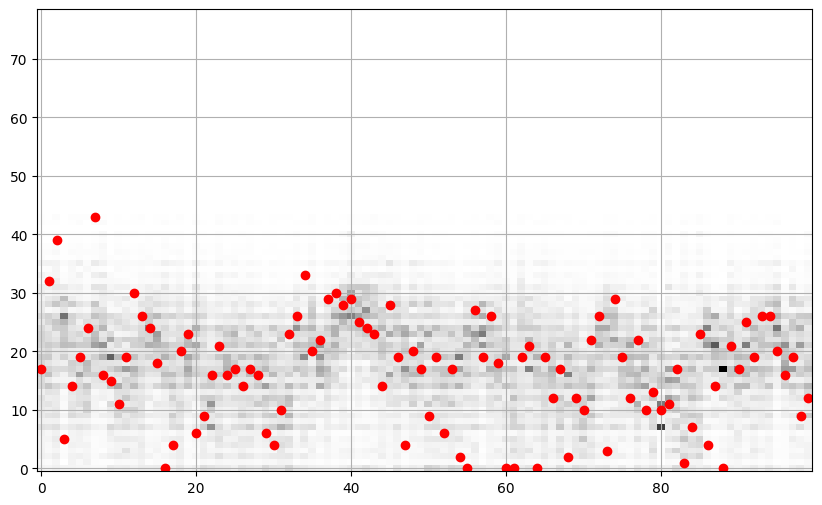

In [82]:
note_l, prediction_l = F_sample_new_sequence(model)

print(note_l)
plt.figure(figsize=(10, 6))
plt.imshow(np.asarray(prediction_l).T, aspect='auto', origin='lower')
plt.plot(note_l, 'ro')
plt.set_cmap('gray_r')
plt.grid(True)

### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [83]:
new_midi_data = pretty_midi.PrettyMIDI()
piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
piano = pretty_midi.Instrument(program=piano_program)
time = 0
step = 0.3
note_l = np.array(note_l)
note_l += 50 #So we hear something pleasant other than bass
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    piano.notes.append(myNote)
    time += step
new_midi_data.instruments.append(piano)

In [84]:
%matplotlib inline

audio_data = new_midi_data.synthesize()
IPython.display.Audio(audio_data, rate=44100)